### iLQR template code

Author: Max Muchen Sun

Date: May 5, 2025

*An example of using "solve_bvp" is included in "ME314OptimalControlNotes.pdf* on Canvas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

In [ ]:
### define parameters

dt = 0.1
x0 = np.array([0.0, 0.0, np.pi/2.0])
tsteps = 63
init_u_traj = np.tile(np.array([1.0, -0.5]), reps=(tsteps,1))

Q_x = np.diag([10.0, 10.0, 2.0])
R_u = np.diag([4.0, 2.0])
P1 = np.diag([20.0, 20.0, 5.0])

Q_z = np.diag([5.0, 5.0, 1.0])
R_v = np.diag([2.0, 1.0])

In [ ]:
def dyn(xt, ut):
    xdot = np.zeros(3)  # replace this
    return xdot


def get_A(t, xt, ut):
    A = np.zeros((3,3))  # replace this
    return A


def get_B(t, xt, ut):
    B = np.zeros((3,2))  # replace this
    return B


def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)  # recommended: replace it with RK4 integration
    return xt_new


def traj_sim(x0, ulist):
    tsteps = ulist.shape[0]
    x_traj = np.zeros((tsteps, 3))
    xt = x0.copy()
    for t in range(tsteps):
        xt_new = step(xt, ulist[t])
        x_traj[t] = xt_new.copy()
        xt = xt_new.copy()
    return x_traj


def loss(t, xt, ut):
    xd = np.array([
        2.0*t / np.pi, 0.0, np.pi/2.0
    ])  # desired system state at time t

    x_loss = 0.0  # replace this
    u_loss = 0.0  # replace this

    return x_loss + u_loss


def dldx(t, xt, ut):
    xd = np.array([
        2.0*t / np.pi, 0.0, np.pi/2.0
    ])

    dvec = np.zeros(3)  # replace this
    return dvec


def dldu(t, xt, ut):
    dvec = np.zeros(2)  # replace this
    return dvec

In [ ]:
def ilqr_iter(x0, u_traj):
    """
    :param x0: initial state of the system
    :param u_traj: current estimation of the optimal control trajectory
    :return: the descent direction for the control
    """
    # forward simulate the state trajectory
    x_traj = traj_sim(x0, u_traj)

    # compute other variables needed for specifying the dynamics of z(t) and p(t)
    A_list = np.zeros((tsteps, 3, 3))
    B_list = np.zeros((tsteps, 3, 2))
    a_list = np.zeros((tsteps, 3))
    b_list = np.zeros((tsteps, 2))
    for t_idx in range(tsteps):
        t = t_idx * dt
        A_list[t_idx] = get_A(t, x_traj[t_idx], u_traj[t_idx])
        B_list[t_idx] = get_B(t, x_traj[t_idx], u_traj[t_idx])
        a_list[t_idx] = dldx(t, x_traj[t_idx], u_traj[t_idx])
        b_list[t_idx] = dldu(t, x_traj[t_idx], u_traj[t_idx])

    xd_T = np.array([
        2.0*(tsteps-1)*dt / np.pi, 0.0, np.pi/2.0
    ])  # desired terminal state
    p1 = np.zeros(3)  # replace it to be the terminal condition p(T)

    def zp_dyn(t, zp):
        t_idx = (t/dt).astype(int)
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        at = a_list[t_idx]
        bt = b_list[t_idx]

        M_11 = np.zeros((3,3))  # replace this
        M_12 = np.zeros((3,3))  # replace this
        M_21 = np.zeros((3,3))  # replace this
        M_22 = np.zeros((3,3))  # replace this
        dyn_mat = np.block([
            [M_11, M_12],
            [M_21, M_22]
        ])

        m_1 = np.zeros(3)  # replace this
        m_2 = np.zeros(3)  # replace this
        dyn_vec = np.hstack([m_1, m_2])

        return dyn_mat @ zp + dyn_vec

    # this will be the actual dynamics function you provide to solve_bvp,
    # it takes in a list of time steps and corresponding [z(t), p(t)]
    # and returns a list of [zdot(t), pdot(t)]
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((6, list_len))
        for _i in range(list_len):
            zp_dot_list[:,_i] = zp_dyn(t_list[_i], zp_list[:,_i])
        return zp_dot_list

    # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
    def zp_bc(zp_0, zp_T):
        return np.zeros(6)  # replace this

    ### The solver will say it does not converge, but the returned result
    ### is numerically accurate enough for our use
    # zp_traj = np.zeros((tsteps,6))  # replace this by using solve_bvp
    tlist = np.arange(tsteps) * dt
    res = solve_bvp(
        zp_dyn_list, zp_bc, tlist, np.zeros((6,tsteps)),
        max_nodes=100
    )
    zp_traj = res.sol(tlist).T

    z_traj = zp_traj[:,:3]
    p_traj = zp_traj[:,3:]

    v_traj = np.zeros((tsteps, 2))
    for _i in range(tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_traj[_i]
        pt = p_traj[_i]

        vt = np.zeros(2)  # replace this
        v_traj[_i] = vt

    return v_traj

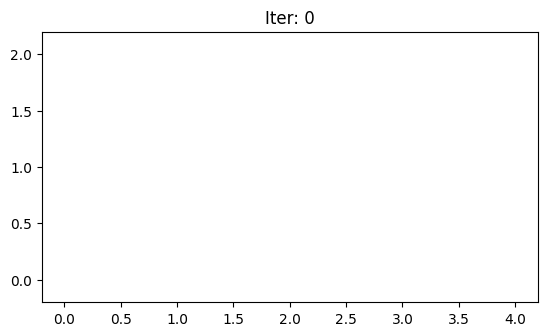

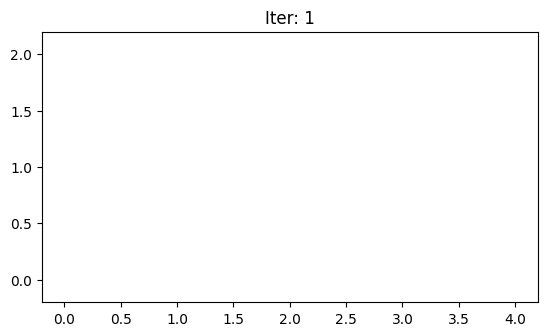

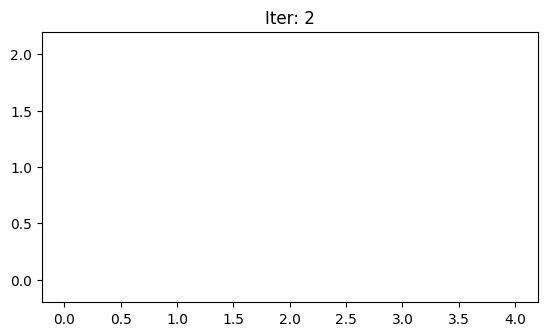

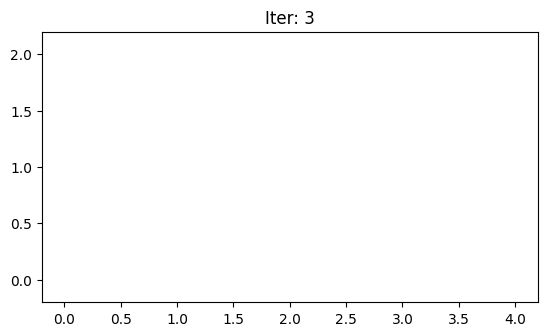

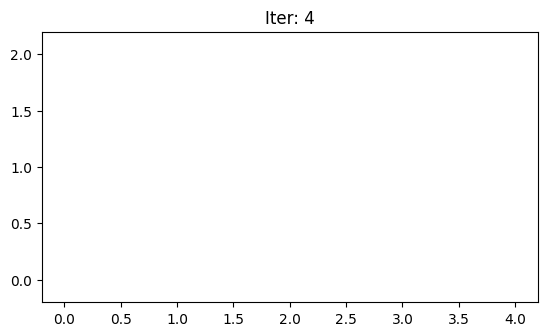

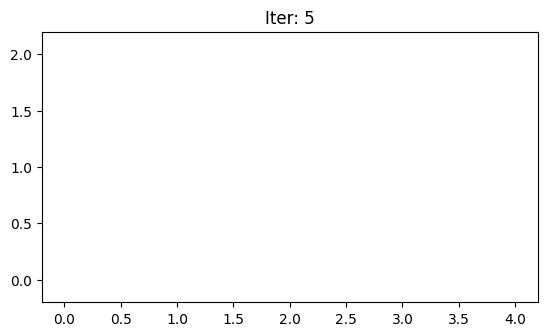

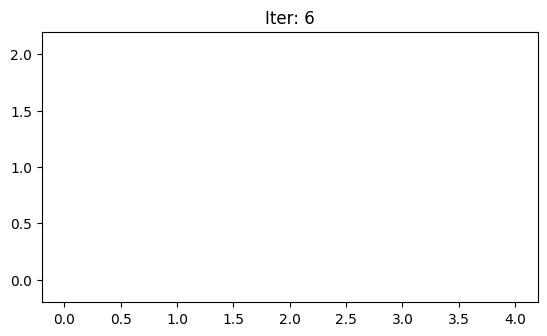

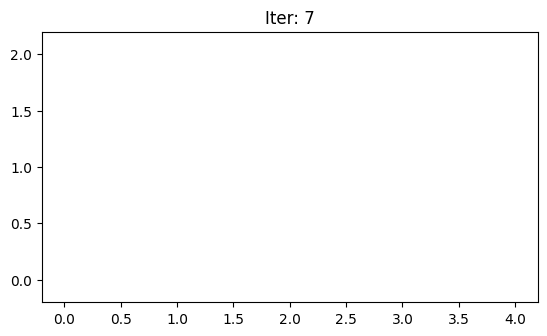

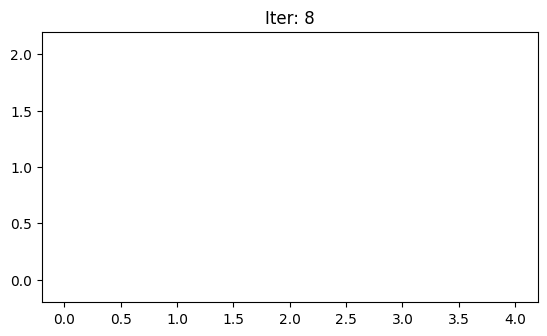

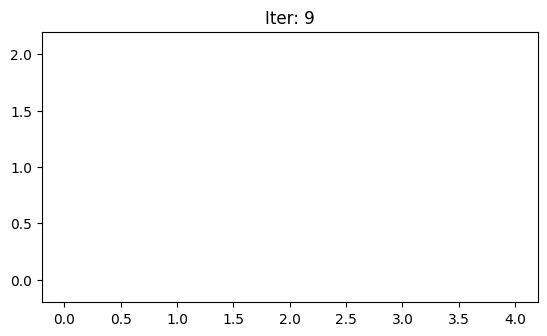

In [ ]:
# Start iLQR iterations here

u_traj = init_u_traj.copy()
for iter in range(10):
    # forward simulate the current trajectory
    x_traj = traj_sim(x0, u_traj)

    # visualize the current trajectory
    fig, ax = plt.subplots(1, 1)
    ax.set_title('Iter: {:d}'.format(iter))
    ax.set_aspect('equal')
    ax.set_xlim(-0.2, 4.2)
    ax.set_ylim(-0.2, 2.2)
    ax.plot(x_traj[:,0], x_traj[:,1], linestyle='-', color='C0')
    plt.show()
    plt.close()

    # get descent direction
    v_traj = ilqr_iter(x0, u_traj)

    # Armijo line search parameters
    gamma = 1.0  # initial step size
    alpha = 1e-04
    beta = 0.5

    ### Implement Armijo line search here to update step size gamma

    # update control for the next iteration
    u_traj += gamma * v_traj